#Modelo de clasificación: Procesado completo + Afinamiento de Técnicas para Red Neuronal

En base a los resultados iniciales con la experimentación mediante un modelo por redes neuronales, este Notebook es un análisis extensivo que busca implementar diferentes técnicas de procesado adicionales y observar las dificultades propias del dataset. El análisis parte de los resultados previos en que una descomposición en componentes PCA mejora el rendimiento de los modelos y de las dificultades existententes con el programa académico. En este orden de ideas se análiza el comportamiento de los modelos aplicando

1. Target encoding a la columna de programa y Labeling para posterior embedding
2. Target encoding a las columnas de programa y educación de los padres
3. Conservación de la clasificación por áreas de conocimiento o no
4. Normalización y escalado

El rendimiento parece llegar a un tope que esta limitado por el propio conjunto de datos y se hacen evaluaciones profundas para encontrar mejoras posibles como modelos mixtos o aplicar una técnica final de embedding

Se hacen uso de varias de las herramientas de tensorflow y de Keras tuner con el ojetivo de encontrar un modelo optimo

##Instrucciones Generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [ ]:
import numpy as np
import pandas as pd

try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass

import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Using TF2 in Google Colab


##Preprocesado de los datos

###Carga de los datos

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.15GB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy


In [ ]:
def process_data(df):

  try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
  except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Dataframe resultante

In [ ]:
df = pd.read_csv("train.csv")
df = process_data(df)

/tmp/ipython-input-4-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


###Separación de los datos

####Con areas de conocimiento

In [ ]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 58)
(692500,)


####Solo target encoding

In [ ]:
programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
knowledge_area = programs_df['CATEGORIA'].unique().tolist() + ['OTRO']
X_target = X.drop(columns=knowledge_area)
print(X_target.shape)
X_target.head()

(692500, 48)


,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4
0,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,1,11,0.322,0.208,0.310,0.267
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,5,0.311,0.215,0.292,0.264
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,4,0.297,0.214,0.305,0.264
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,4,0.485,0.172,0.252,0.190
4,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,2,0.316,0.232,0.285,0.294


##Creación y evaluacion del modelo

###Modelo y calibración

####Target-encoding para programas

In [ ]:
def target_encoding(X, y, col):
  encoding_df = pd.DataFrame({col: X[col], 'TARGET': y})
  mean_target_per_col = encoding_df.groupby(col)['TARGET'].mean()
  return mean_target_per_col

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3)

X_program = X.copy()

for col in ['ESTU_PRGM_ACADEMICO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
  mean_target_col = target_encoding(Xtr, ytr, col)
  X[col] = X[col].map(mean_target_col).fillna(ytr.mean())
  X_target[col] = X_target[col].map(mean_target_col).fillna(ytr.mean())
  if col == 'ESTU_PRGM_ACADEMICO':
    X_program[col] = X_program[col].map(mean_target_col).fillna(ytr.mean())


####Normalización columnas

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA',
                'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

float_cols = ['coef_1', 'coef_2', 'coef_3', 'coef_4', 'ESTU_PRGM_ACADEMICO']

binary_cols = [col for col in X.columns if col not in ordinal_cols + float_cols]
binary_target_cols = [col for col in X_target.columns if col not in ordinal_cols + float_cols]

preprocessor = ColumnTransformer([
    ('scale_ord', StandardScaler(), ordinal_cols + float_cols),
    ('passthrough_bin', 'passthrough', binary_cols)
])

preprocessor_target = ColumnTransformer([
    ('scale_ord', StandardScaler(), ordinal_cols + float_cols),
    ('passthrough_bin', 'passthrough', binary_target_cols)
])

X_scaled = preprocessor.fit_transform(X)
X_program_scaled = preprocessor.fit_transform(X_program)
X_target_scaled = preprocessor_target.fit_transform(X_target)

####Descomposición PCA

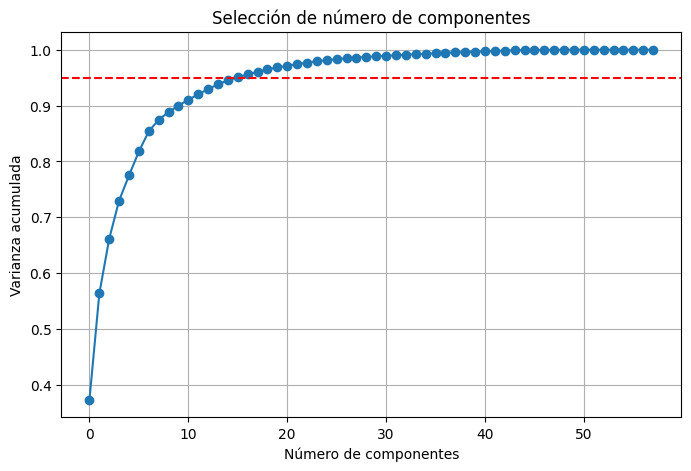

Se necesitan 16 componentes para conservar el 95% de la varianza


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)

# Varianza acumulada
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--')  # Umbral deseado
plt.title("Selección de número de componentes")
plt.show()

# Elegir el número que conserve al menos el 95%
n_components = np.argmax(cumulative_var >= 0.95) + 1
print(f"Se necesitan {n_components} componentes para conservar el 95% de la varianza")

#####Exploración inicial de descomposición optima

In [ ]:
from sklearn.model_selection import train_test_split

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def evaluate(model, X, y):
  _, acc = model.evaluate(X, y, verbose=0)
  return acc

def bootstrap_score(X, y, test_size, iterations=3):
  trscores, tsscores = [], []
  for _ in range(iterations):

    model = build_model()
    Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=test_size)
    ytr = pd.get_dummies(ytr).astype(int)
    yts = pd.get_dummies(yts).astype(int)
    model.fit(Xtr, ytr, epochs=10, batch_size=512,verbose=0)
    trscores.append(evaluate(model, Xtr, ytr))
    tsscores.append(evaluate(model, Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

#####Con areas de conocimiento

In [ ]:
max_acc = 0
n_components = 10

for i in range(10, X.shape[1], 6):
  pca = PCA(n_components=i)
  pca.fit(X_scaled)
  X_pca = pca.transform(X_scaled)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

max_acc = 0

for i in range(n_components-3, min(n_components+4, X.shape[1])):
  pca = PCA(n_components=i)
  pca.fit(X_scaled)
  X_pca = pca.transform(X_scaled)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")


print(f"Best decomposition with {n_components}")

Decomposition with 10 components. Train accuracy 0.419731 ­± 0.000205, Test accuracy: 0.418683 ± 0.000780
Decomposition with 16 components. Train accuracy 0.424525 ­± 0.000557, Test accuracy: 0.423342 ± 0.000799
Decomposition with 22 components. Train accuracy 0.426365 ­± 0.000184, Test accuracy: 0.424791 ± 0.000478
Decomposition with 28 components. Train accuracy 0.429022 ­± 0.000122, Test accuracy: 0.426514 ± 0.000805
Decomposition with 34 components. Train accuracy 0.431436 ­± 0.000368, Test accuracy: 0.428882 ± 0.001080
Decomposition with 40 components. Train accuracy 0.432455 ­± 0.000562, Test accuracy: 0.429462 ± 0.001185
Decomposition with 46 components. Train accuracy 0.435024 ­± 0.000413, Test accuracy: 0.430628 ± 0.000266
Decomposition with 52 components. Train accuracy 0.435074 ­± 0.000082, Test accuracy: 0.431909 ± 0.001340
Decomposition with 43 components. Train accuracy 0.434307 ­± 0.000435, Test accuracy: 0.430153 ± 0.000373
Decomposition with 44 components. Train accura

#####Solo target encoding

In [ ]:
max_acc = 0
n_components = 10

for i in range(10, X_target.shape[1], 6):
  pca = PCA(n_components=i)
  pca.fit(X_target_scaled)
  X_pca = pca.transform(X_target_scaled)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

max_acc = 0

for i in range(n_components-3, min(n_components+4, X_target.shape[1])):
  pca = PCA(n_components=i)
  pca.fit(X_scaled)
  X_pca = pca.transform(X_scaled)

  tr_sc, ts_sc = bootstrap_score(X_pca, y, 0.3)

  if ts_sc[0] - ts_sc[1] > max_acc:
    max_acc = ts_sc[0]
    n_components = i

  print(f"Decomposition with {i} components. Train accuracy {tr_sc[0]:6f} ­± {tr_sc[1]:6f}, Test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")


print(f"Best decomposition with {n_components}")

Decomposition with 10 components. Train accuracy 0.420138 ­± 0.001321, Test accuracy: 0.418559 ± 0.001826
Decomposition with 16 components. Train accuracy 0.423726 ­± 0.000378, Test accuracy: 0.422768 ± 0.000603
Decomposition with 22 components. Train accuracy 0.425667 ­± 0.000659, Test accuracy: 0.424616 ± 0.000450
Decomposition with 28 components. Train accuracy 0.428643 ­± 0.000490, Test accuracy: 0.425584 ± 0.000911
Decomposition with 34 components. Train accuracy 0.430003 ­± 0.000491, Test accuracy: 0.428027 ± 0.000451
Decomposition with 40 components. Train accuracy 0.431537 ­± 0.000067, Test accuracy: 0.428051 ± 0.001343
Decomposition with 46 components. Train accuracy 0.431326 ­± 0.000633, Test accuracy: 0.429864 ± 0.000529
Decomposition with 43 components. Train accuracy 0.433343 ­± 0.000407, Test accuracy: 0.430490 ± 0.001116
Decomposition with 44 components. Train accuracy 0.434215 ­± 0.000846, Test accuracy: 0.430113 ± 0.000720
Decomposition with 45 components. Train accura

####Creando la red neuronal aplicando PCA

In [ ]:
pca = PCA(n_components=45)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_program_pca = pca.transform(X_program_scaled)

In [ ]:
pca = PCA(n_components=46)
pca.fit(X_target_scaled)
X_target_pca = pca.transform(X_target_scaled)

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X_pca,y, test_size=0.3)
Xtr_target, Xts_target, ytr_target, yts_target = train_test_split(X_target_pca,y, test_size=0.3)
Xtr_program, Xts_program, ytr_program, yts_program = train_test_split(X_program_pca,y, test_size=0.3)

#####One-hot encoding variable salida

In [ ]:
print(ytr.shape)
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)
ytr_target = pd.get_dummies(ytr_target).astype(int)
yts_target = pd.get_dummies(yts_target).astype(int)
ytr_program = pd.get_dummies(ytr_program).astype(int)
yts_program = pd.get_dummies(yts_program).astype(int)
print(ytr.shape)

(484750,)
(484750, 4)


#####Sin capas intermedias

######Con areas de conocimiento

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(4, activation='softmax'),
  ])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=20, batch_size=512)
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print()
print(f"Train accuracy {acc_tr}, Test accuracy: {acc}")

Epoch 1/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3503 - loss: 1.3772
Epoch 2/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4092 - loss: 1.2408
Epoch 3/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4104 - loss: 1.2402
Epoch 4/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4099 - loss: 1.2399
Epoch 5/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4106 - loss: 1.2397
Epoch 6/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4102 - loss: 1.2404
Epoch 7/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4098 - loss: 1.2398
Epoch 8/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4104 - loss: 1.2399
Epoch 9/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4106 - loss: 1.2392
Epoch 10/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4083 - loss: 1.2405
Epoch 11/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4097 - loss: 1.2403
Epoch 12/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/ste

######Solo target encoding

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(4, activation='softmax'),
  ])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(Xtr_target, ytr_target, epochs=20, batch_size=512)
_, acc = model.evaluate(Xts_target, yts_target,verbose=0)
_, acc_tr = model.evaluate(Xtr_target, ytr_target,verbose=0)
print()
print(f"Train accuracy {acc_tr}, Test accuracy: {acc}")

Epoch 1/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3400 - loss: 1.3925
Epoch 2/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4083 - loss: 1.2412
Epoch 3/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4106 - loss: 1.2382
Epoch 4/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4098 - loss: 1.2385
Epoch 5/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4108 - loss: 1.2392
Epoch 6/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4089 - loss: 1.2383
Epoch 7/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4086 - loss: 1.2403
Epoch 8/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4095 - loss: 1.2391
Epoch 9/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4095 - loss: 1.2403
Epoch 10/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4094 - loss: 1.2384
Epoch 11/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4091 - loss: 1.2385
Epoch 12/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

#####Una capa intermedia

######Con areas de conocimiento

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=10, batch_size=512,verbose=0)
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Train accuracy: 0.43178752064704895, Test accuracy: 0.42969435453414917


######Solo target encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(Xtr_target, ytr_target, epochs=10, batch_size=512,verbose=0)
_, acc = model.evaluate(Xts_target, yts_target,verbose=0)
_, acc_tr = model.evaluate(Xtr_target, ytr_target,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Train accuracy: 0.42926251888275146, Test accuracy: 0.42693620920181274


#####Dos capas intermedias

######Con areas de conocimiento

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3958 - loss: 1.2569 - val_accuracy: 0.4258 - val_loss: 1.2145
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4227 - loss: 1.2216 - val_accuracy: 0.4299 - val_loss: 1.2097
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4249 - loss: 1.2167 - val_accuracy: 0.4300 - val_loss: 1.2084
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4267 - loss: 1.2148 - val_accuracy: 0.4304 - val_loss: 1.2076
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4282 - loss: 1.2145 - val_accuracy: 0.4325 - val_loss: 1.2055
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4278 - loss: 1.2138 - val_accuracy: 0.4318 - val_loss: 1.2045
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4285 - loss: 1.2128 - val_accuracy: 0.4324 - val_loss: 1.2039
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.4295 - loss: 1.2105 - val_acc

In [ ]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

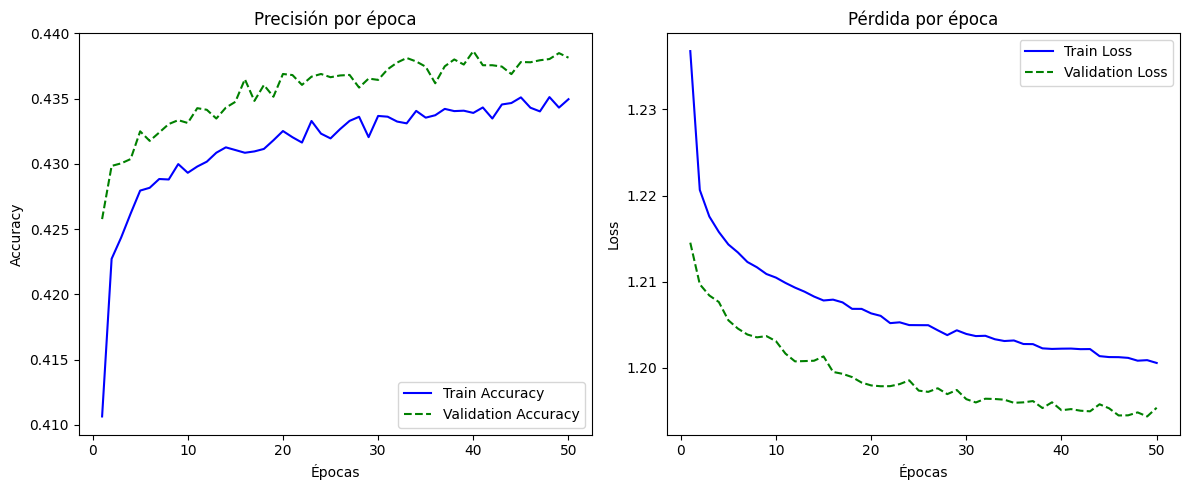

In [ ]:
plot_training_history(history)

######Solo target encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr_target, ytr_target, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts_target, yts_target,verbose=0)
_, acc_tr = model.evaluate(Xtr_target, ytr_target,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4006 - loss: 1.2528 - val_accuracy: 0.4272 - val_loss: 1.2159
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4220 - loss: 1.2218 - val_accuracy: 0.4288 - val_loss: 1.2128
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4236 - loss: 1.2194 - val_accuracy: 0.4299 - val_loss: 1.2118
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4253 - loss: 1.2158 - val_accuracy: 0.4312 - val_loss: 1.2106
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4264 - loss: 1.2163 - val_accuracy: 0.4313 - val_loss: 1.2094
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4259 - loss: 1.2153 - val_accuracy: 0.4300 - val_loss: 1.2090
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4275 - loss: 1.2153 - val_accuracy: 0.4303 - val_loss: 1.2084
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4269 - loss: 1.2130 - val_accuracy

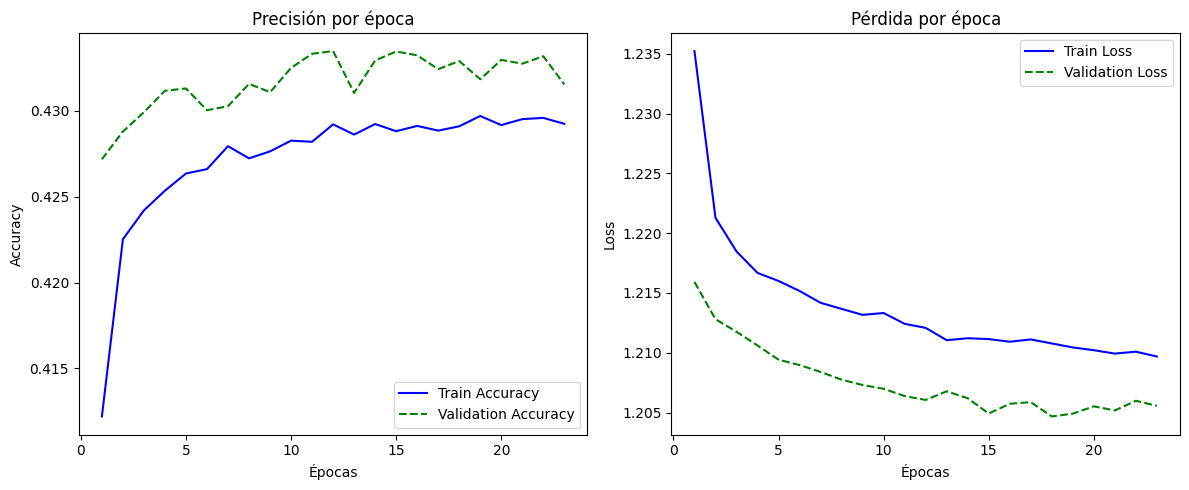

In [ ]:
plot_training_history(history)

Aplicar el target encoding sobre la columna de programas ayuda a obtener mejores predicciones, los resultados conservando o no las columnas de clasificación por áreas de conocimiento no son significativamente diferentes, tendiendo a ser mejor con el dataset completo. Se continua la evaluación para dicho caso

#####Tres capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.4047 - loss: 1.2482 - val_accuracy: 0.4259 - val_loss: 1.2168
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4231 - loss: 1.2207 - val_accuracy: 0.4269 - val_loss: 1.2125
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.4250 - loss: 1.2160 - val_accuracy: 0.4272 - val_loss: 1.2119
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4265 - loss: 1.2144 - val_accuracy: 0.4309 - val_loss: 1.2076
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4292 - loss: 1.2106 - val_accuracy: 0.4307 - val_loss: 1.2077
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4295 - loss: 1.2106 - val_accuracy: 0.4312 - val_loss: 1.2049
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4312 - loss: 1.2075 - val_accuracy: 0.4322 - val_loss: 1.2033
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4299 - loss: 1.2076 - v

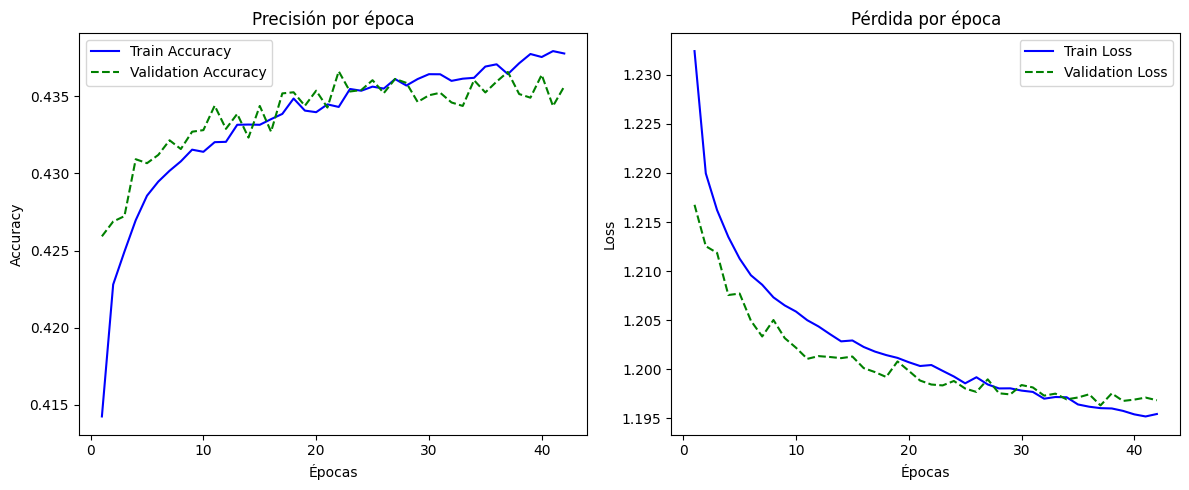

In [ ]:
plot_training_history(history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr_program, ytr_program, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts_program, yts_program,verbose=0)
_, acc_tr = model.evaluate(Xtr_program, ytr_program,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4028 - loss: 1.2507 - val_accuracy: 0.4281 - val_loss: 1.2136
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4224 - loss: 1.2223 - val_accuracy: 0.4304 - val_loss: 1.2109
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4248 - loss: 1.2178 - val_accuracy: 0.4311 - val_loss: 1.2073
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4259 - loss: 1.2158 - val_accuracy: 0.4319 - val_loss: 1.2054
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4291 - loss: 1.2103 - val_accuracy: 0.4314 - val_loss: 1.2047
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4293 - loss: 1.2115 - val_accuracy: 0.4345 - val_loss: 1.2022
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4300 - loss: 1.2106 - val_accuracy: 0.4342 - val_loss: 1.2015
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4306 - loss: 1.2089 - val

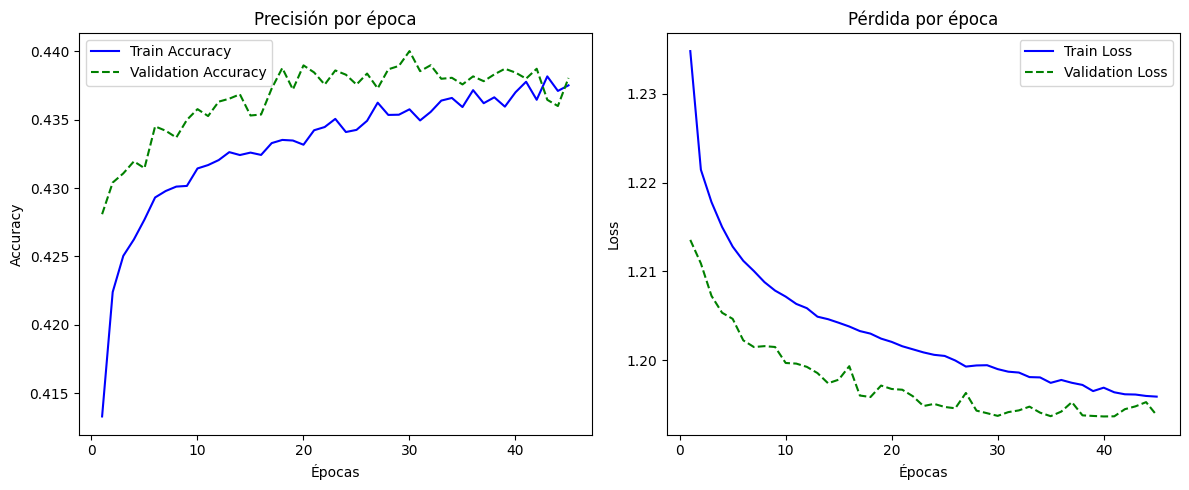

In [ ]:
plot_training_history(history)

In [ ]:
pca = PCA(n_components=45)
pca.fit(X_program)
X_program_pca = pca.transform(X_program)
Xtr_program, Xts_program, ytr_program, yts_program = train_test_split(X_program_pca,y, test_size=0.3)
#

In [ ]:
ytr_program = pd.get_dummies(ytr_program).astype(int)
yts_program = pd.get_dummies(yts_program).astype(int)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr_program, ytr_program, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts_program, yts_program,verbose=0)
_, acc_tr = model.evaluate(Xtr_program, ytr_program,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3963 - loss: 1.2592 - val_accuracy: 0.4253 - val_loss: 1.2180
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4221 - loss: 1.2210 - val_accuracy: 0.4272 - val_loss: 1.2133
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4240 - loss: 1.2176 - val_accuracy: 0.4306 - val_loss: 1.2098
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4279 - loss: 1.2124 - val_accuracy: 0.4298 - val_loss: 1.2087
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4301 - loss: 1.2092 - val_accuracy: 0.4324 - val_loss: 1.2060
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4310 - loss: 1.2080 - val_accuracy: 0.4327 - val_loss: 1.2047
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4297 - loss: 1.2077 - val_accuracy: 0.4318 - val_loss: 1.2040
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4314 - loss: 1.2059 - v

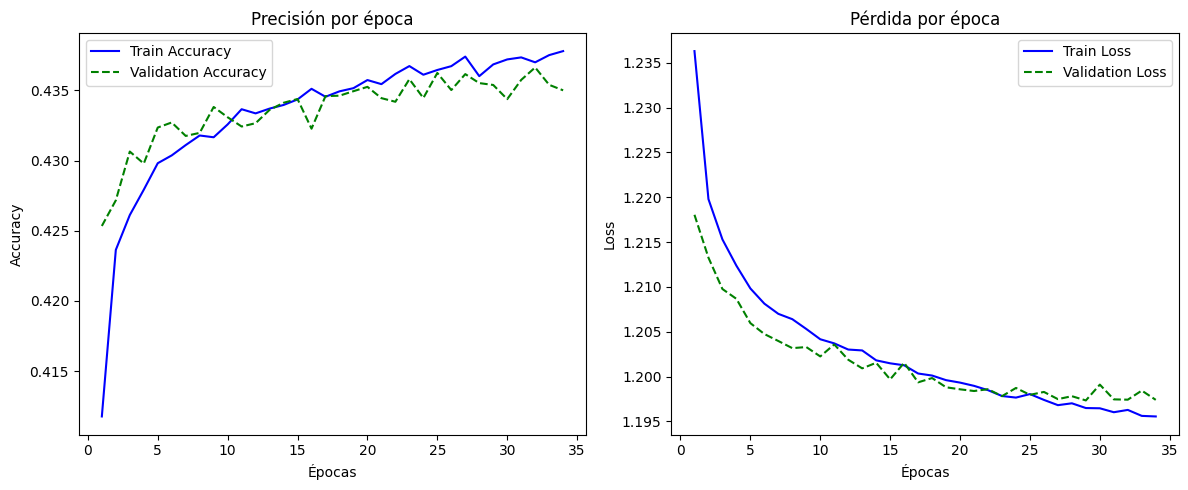

In [ ]:
plot_training_history(history)

#####4 Capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.3981 - loss: 1.2580 - val_accuracy: 0.4254 - val_loss: 1.2141
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4192 - loss: 1.2267 - val_accuracy: 0.4293 - val_loss: 1.2102
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4239 - loss: 1.2215 - val_accuracy: 0.4298 - val_loss: 1.2086
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4258 - loss: 1.2199 - val_accuracy: 0.4309 - val_loss: 1.2051
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.4279 - loss: 1.2167 - val_accuracy: 0.4331 - val_loss: 1.2027
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.4279 - loss: 1.2146 - val_accuracy: 0.4328 - val_loss: 1.2035
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4284 - loss: 1.2134 - val_accuracy: 0.4326 - val_loss: 1.2015
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.4284 - loss: 1.2128 - 

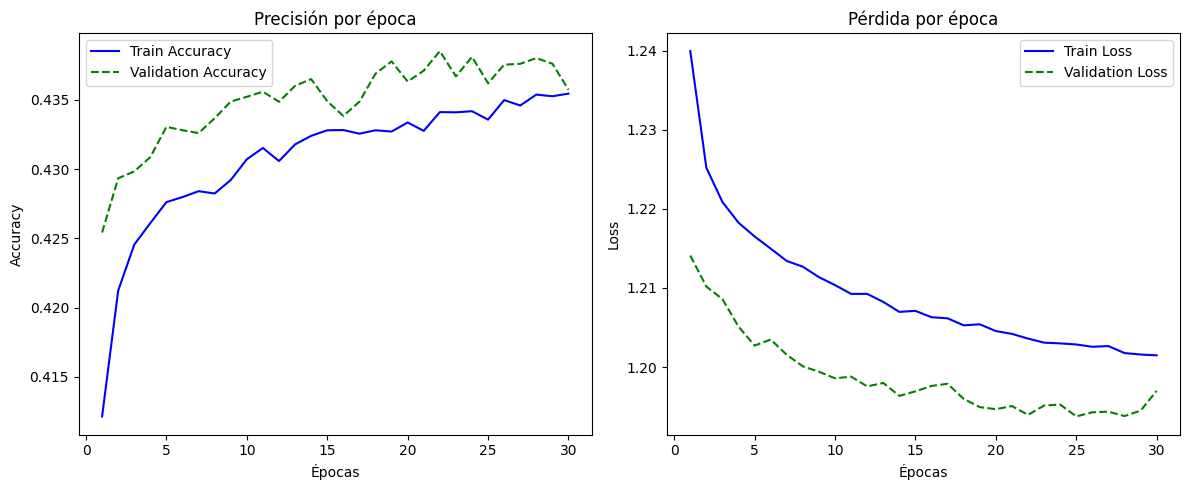

In [ ]:
plot_training_history(history)

#####Examinando capacidad de los datos

In [ ]:
Xtr_rf, Xts_rf, ytr_rf, yts_rf = train_test_split(X, y, test_size=0.3)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(Xtr_rf, ytr_rf)
print(f" Train accuracy: {model.score(Xtr_rf, ytr_rf):6f}, Test accuracy: {model.score(Xts_rf, yts_rf):6f}")

 Train accuracy: 0.427705, Test accuracy: 0.416645


####Creando red neuronal sin PCA

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X_scaled,y, test_size=0.3)
Xtr_target, Xts_target, ytr_target, yts_target = train_test_split(X_target_scaled,y, test_size=0.3)

In [ ]:
print(ytr.shape)
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)
ytr_target = pd.get_dummies(ytr_target).astype(int)
yts_target = pd.get_dummies(yts_target).astype(int)
print(ytr.shape)

(484750,)
(484750, 4)


#####Sin capas intermedias

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(4, activation='softmax'),
  ])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=20, batch_size=512)
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print()
print(f"Train accuracy {acc_tr}, Test accuracy: {acc}")

Epoch 1/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3410 - loss: 1.4154
Epoch 2/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4065 - loss: 1.2433
Epoch 3/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4101 - loss: 1.2399
Epoch 4/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4107 - loss: 1.2381
Epoch 5/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4097 - loss: 1.2391
Epoch 6/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4102 - loss: 1.2375
Epoch 7/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4082 - loss: 1.2397
Epoch 8/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4091 - loss: 1.2385
Epoch 9/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4092 - loss: 1.2390
Epoch 10/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4092 - loss: 1.2375
Epoch 11/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4093 - loss: 1.2383
Epoch 12/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

#####Una capa intermedia

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3852 - loss: 1.2743 - val_accuracy: 0.4205 - val_loss: 1.2203
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4245 - loss: 1.2169 - val_accuracy: 0.4233 - val_loss: 1.2154
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4280 - loss: 1.2139 - val_accuracy: 0.4256 - val_loss: 1.2130
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4264 - loss: 1.2122 - val_accuracy: 0.4259 - val_loss: 1.2122
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4285 - loss: 1.2120 - val_accuracy: 0.4268 - val_loss: 1.2097
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4310 - loss: 1.2089 - val_accuracy: 0.4269 - val_loss: 1.2097
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4310 - loss: 1.2088 - val_accuracy: 0.4281 - val_loss: 1.2087
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4311 - loss: 1.2064 - val_accuracy: 0.

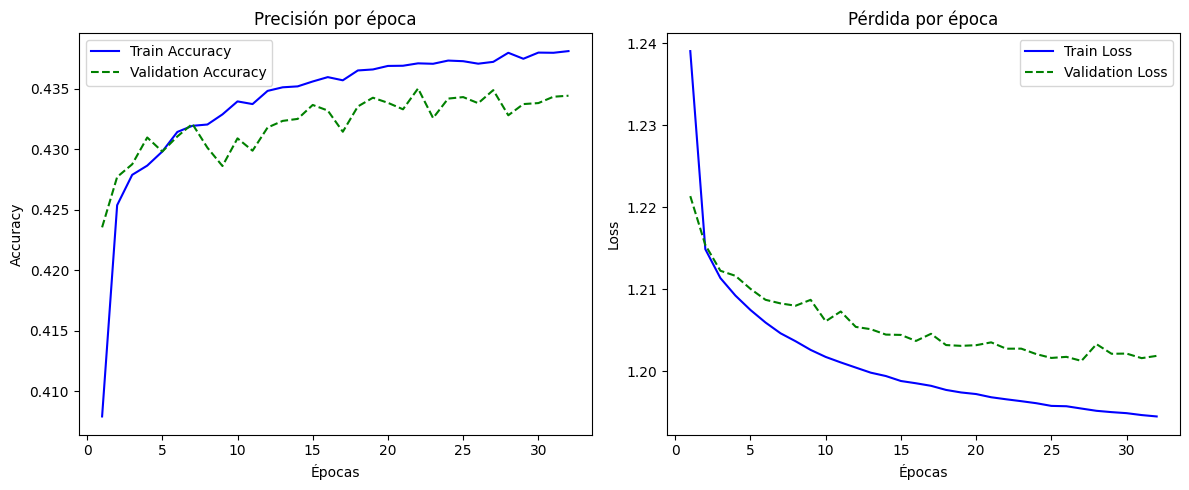

In [ ]:
plot_training_history(history)

#####Dos capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.3919 - loss: 1.2643 - val_accuracy: 0.4240 - val_loss: 1.2177
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4228 - loss: 1.2207 - val_accuracy: 0.4277 - val_loss: 1.2146
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4247 - loss: 1.2185 - val_accuracy: 0.4288 - val_loss: 1.2120
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4269 - loss: 1.2152 - val_accuracy: 0.4306 - val_loss: 1.2096
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4271 - loss: 1.2134 - val_accuracy: 0.4301 - val_loss: 1.2092
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4287 - loss: 1.2120 - val_accuracy: 0.4320 - val_loss: 1.2085
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4287 - loss: 1.2108 - val_accuracy: 0.4299 - val_loss: 1.2079
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4286 - loss: 1.2106 - val_accuracy:

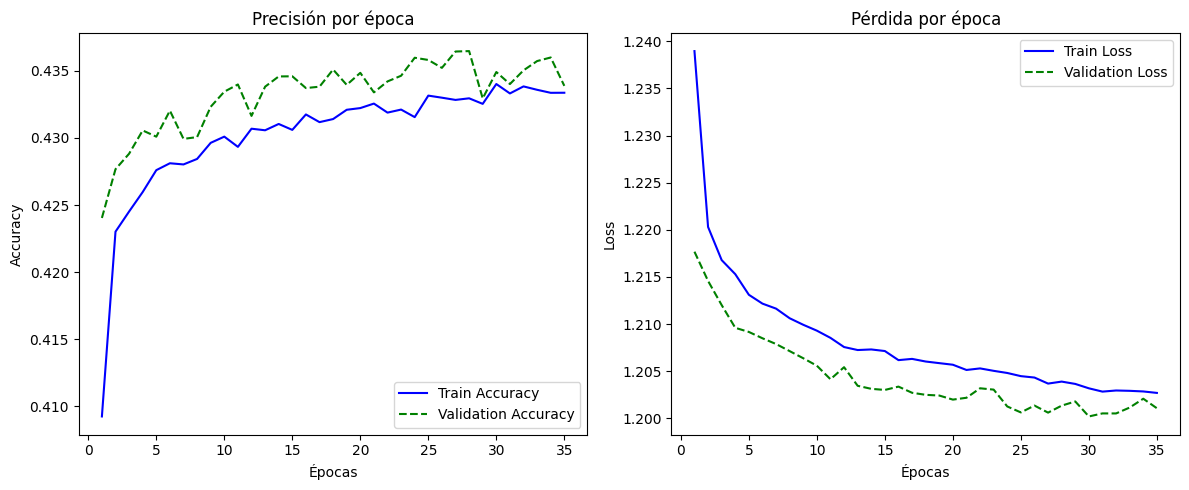

In [ ]:
plot_training_history(history)

#####Tres capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4010 - loss: 1.2508 - val_accuracy: 0.4248 - val_loss: 1.2185
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4208 - loss: 1.2214 - val_accuracy: 0.4268 - val_loss: 1.2137
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4244 - loss: 1.2175 - val_accuracy: 0.4302 - val_loss: 1.2096
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4289 - loss: 1.2117 - val_accuracy: 0.4315 - val_loss: 1.2084
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4281 - loss: 1.2111 - val_accuracy: 0.4323 - val_loss: 1.2056
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4287 - loss: 1.2095 - val_accuracy: 0.4308 - val_loss: 1.2065
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4296 - loss: 1.2082 - val_accuracy: 0.4352 - val_loss: 1.2042
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4319 - loss: 1.2051 - 

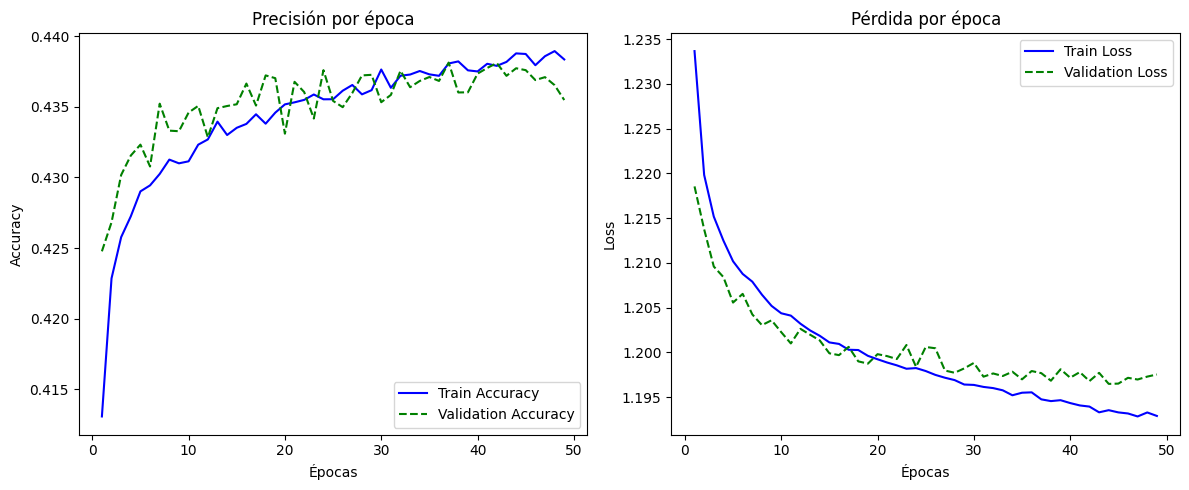

In [ ]:
plot_training_history(history)

#####Cuatro capas intermedias

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr}, Test accuracy: {acc}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.3967 - loss: 1.2593 - val_accuracy: 0.4247 - val_loss: 1.2171
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4201 - loss: 1.2259 - val_accuracy: 0.4278 - val_loss: 1.2127
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.4245 - loss: 1.2204 - val_accuracy: 0.4291 - val_loss: 1.2111
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4256 - loss: 1.2172 - val_accuracy: 0.4295 - val_loss: 1.2111
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4272 - loss: 1.2150 - val_accuracy: 0.4303 - val_loss: 1.2084
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4288 - loss: 1.2141 - val_accuracy: 0.4327 - val_loss: 1.2069
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4283 - loss: 1.2116 - val_accuracy: 0.4337 - val_loss: 1.2051
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4298 - loss: 1.2092 - 

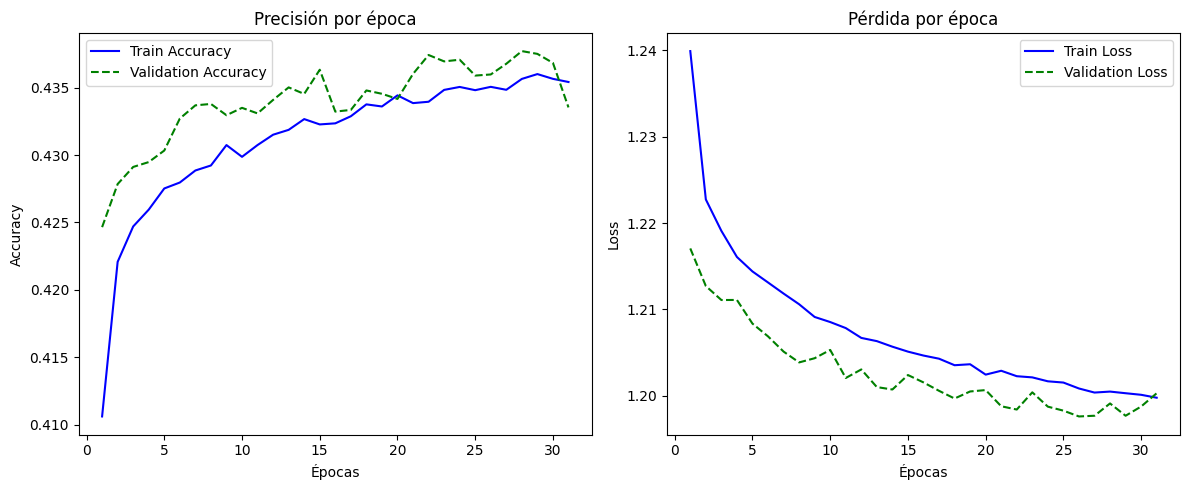

In [ ]:
plot_training_history(history)

Los resultados sin aplicación de una descomposición por componentes principales no es mejor a la aplicación de este. Se conserva entonces el procesamiento con una descomposición PCA

####Encontrando un modelo optimo

A partir de la exploración inicial, se nota que un modelo con tres o máximo cuatro capas ocultas puede ofrecer el mejor resultado. A continuación se hace una búsqueda de los hiperparamétros de red que optimice la predicción

Referencia de resultados con tres capas:
Train accuracy: 0.439546, Test accuracy: 0.436000

######Tres capas

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(360, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr:6f}, Test accuracy: {acc:6f}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4052 - loss: 1.2476 - val_accuracy: 0.4261 - val_loss: 1.2161
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.4225 - loss: 1.2212 - val_accuracy: 0.4285 - val_loss: 1.2113
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.4276 - loss: 1.2146 - val_accuracy: 0.4310 - val_loss: 1.2091
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4299 - loss: 1.2119 - val_accuracy: 0.4314 - val_loss: 1.2083
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4308 - loss: 1.2095 - val_accuracy: 0.4314 - val_loss: 1.2057
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4307 - loss: 1.2084 - val_accuracy: 0.4326 - val_loss: 1.2049
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4326 - loss: 1.2063 - val_accuracy: 0.4339 - val_loss: 1.2031
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4319 - loss: 1.2056 - va

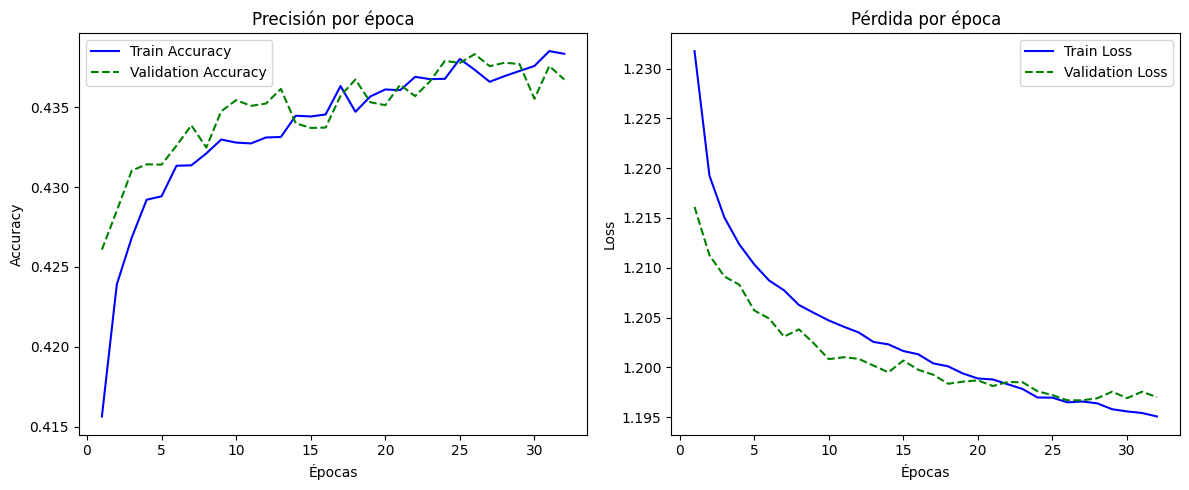

In [ ]:
plot_training_history(history)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(Xts)
print(classification_report(yts.values.argmax(axis=1), y_pred.argmax(axis=1)))

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
              precision    recall  f1-score   support

           0       0.47      0.53      0.50     51882
           1       0.33      0.30      0.32     51794
           2       0.33      0.26      0.29     51387
           3       0.55      0.63      0.59     52687

    accuracy                           0.43    207750
   macro avg       0.42      0.43      0.42    207750
weighted avg       0.42      0.43      0.43    207750



Los diferentes ajustes realizados al modelo no muestran incrementos más allá del 43% de acierto por lo que se hace una evaluación de los resultados mediante una matriz de confusión que permita identificar en que categorías se equivoca más el modelo

######Evaluación de predicción

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


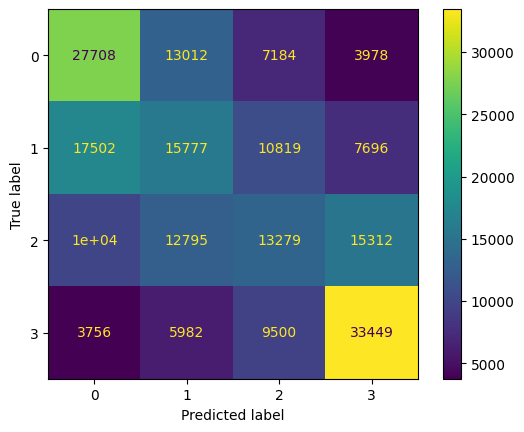

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(Xts)
ConfusionMatrixDisplay.from_predictions(yts.values.argmax(axis=1), y_pred.argmax(axis=1))

El modelo tiene dificultades de predicción para las clases 1 y 2. A continuación vemos como el desempeño mejora notablemente si se agrupan estas dos clases en una sola

In [ ]:
y_grouped = pd.Series(np.where(y == 3, 2,
                       np.where(y == 2, 1,
                       np.where(y == 1, 1,
                       0))))

Xtr_grouped, Xts_grouped, ytr_grouped, yts_grouped = train_test_split(X_pca, y_grouped, test_size=0.3)

In [ ]:
ytr_grouped = pd.get_dummies(ytr_grouped).astype(int)
yts_grouped = pd.get_dummies(yts_grouped).astype(int)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(360, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Xtr_grouped, ytr_grouped, epochs=50, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts_grouped, yts_grouped,verbose=0)
_, acc_tr = model.evaluate(Xtr_grouped, ytr_grouped,verbose=0)
print(f"Train accuracy: {acc_tr:6f}, Test accuracy: {acc:6f}")

Epoch 1/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5508 - loss: 0.9181 - val_accuracy: 0.5723 - val_loss: 0.8859
Epoch 2/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5707 - loss: 0.8891 - val_accuracy: 0.5734 - val_loss: 0.8827
Epoch 3/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5749 - loss: 0.8856 - val_accuracy: 0.5752 - val_loss: 0.8808
Epoch 4/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5753 - loss: 0.8835 - val_accuracy: 0.5777 - val_loss: 0.8789
Epoch 5/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5759 - loss: 0.8813 - val_accuracy: 0.5773 - val_loss: 0.8776
Epoch 6/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5770 - loss: 0.8788 - val_accuracy: 0.5798 - val_loss: 0.8748
Epoch 7/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5775 - loss: 0.8785 - val_accuracy: 0.5774 - val_loss: 0.8763
Epoch 8/50
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5773 - loss: 0.8786 - 

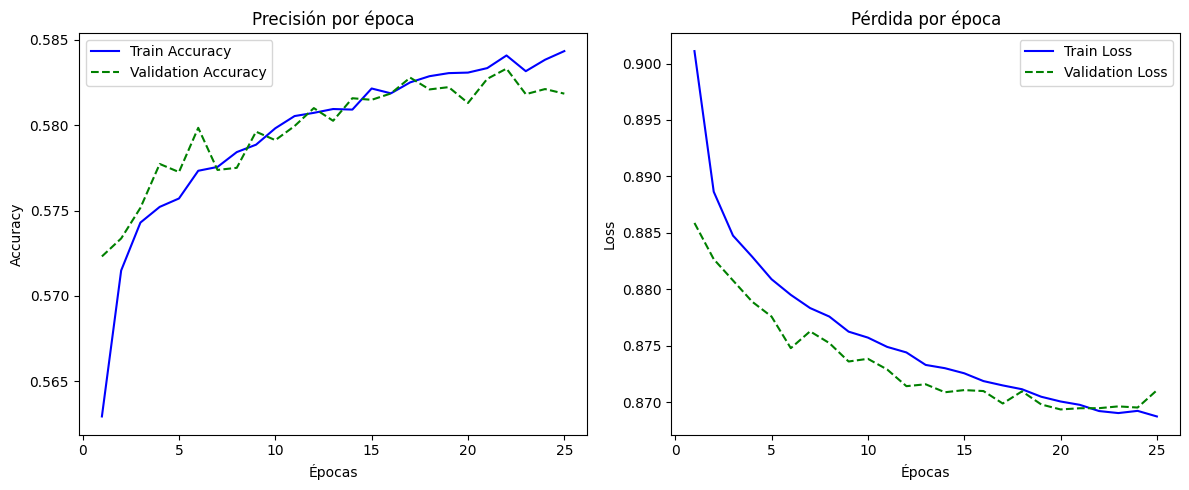

In [ ]:
plot_training_history(history)

######Usando función de perdida focalizada

Se busca entonces aplicar una función de perdida focal que permita que el modelo aprenda a predecir mejor estas clases donde tiene más dificultades. Se implementa función de perdida o se puede utilizar la función de perdida focalizada que ofrece la librería de tensorflow: CategoricalFocalCrossentropy

In [ ]:
def focal_loss(gamma=2.0, alpha=None):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        ce = -y_true * tf.math.log(y_pred)
        if alpha is not None:
            ce *= alpha
        fl = tf.pow(1 - y_pred, gamma) * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return loss_fn

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(360, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax'),
])

alpha = tf.constant([1.2, 1.4, 1.4, 1.2], dtype=tf.float32)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = focal_loss(gamma=0.50, alpha=alpha),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(Xtr, ytr, epochs=60, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])
_, acc = model.evaluate(Xts, yts,verbose=0)
_, acc_tr = model.evaluate(Xtr, ytr,verbose=0)
print(f"Train accuracy: {acc_tr:6f}, Test accuracy: {acc:6f}")

Epoch 1/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3974 - loss: 1.3906 - val_accuracy: 0.4216 - val_loss: 1.3469
Epoch 2/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4184 - loss: 1.3531 - val_accuracy: 0.4252 - val_loss: 1.3422
Epoch 3/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4222 - loss: 1.3473 - val_accuracy: 0.4220 - val_loss: 1.3418
Epoch 4/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4233 - loss: 1.3429 - val_accuracy: 0.4270 - val_loss: 1.3359
Epoch 5/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4257 - loss: 1.3411 - val_accuracy: 0.4298 - val_loss: 1.3351
Epoch 6/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4275 - loss: 1.3368 - val_accuracy: 0.4299 - val_loss: 1.3356
Epoch 7/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4280 - loss: 1.3353 - val_accuracy: 0.4334 - val_loss: 1.3328
Epoch 8/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4290 - loss: 1.3356 - val_a

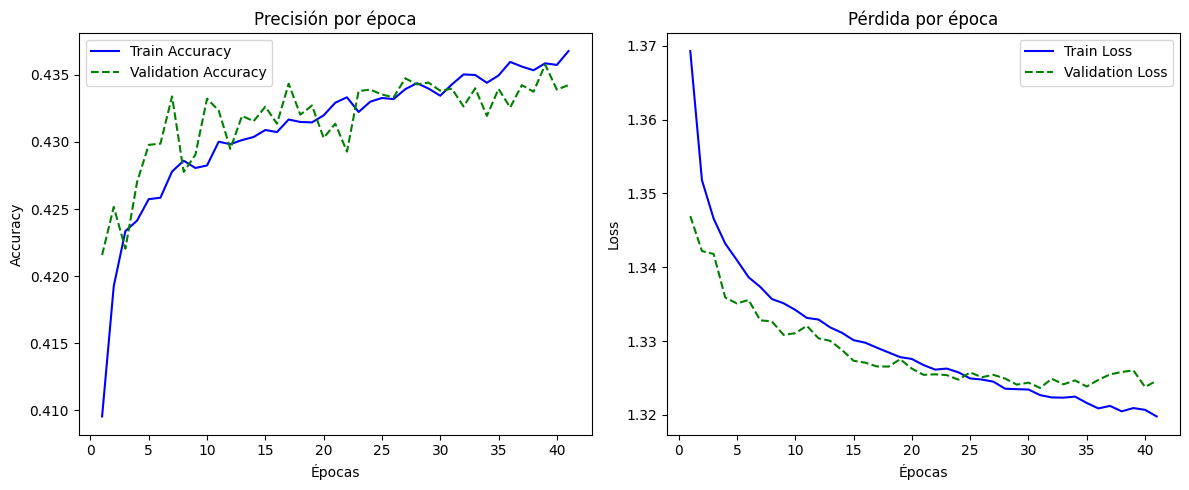

In [ ]:
plot_training_history(history)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(Xts)
print(classification_report(yts.values.argmax(axis=1), y_pred.argmax(axis=1)))

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step
              precision    recall  f1-score   support

           0       0.50      0.45      0.48     51882
           1       0.33      0.38      0.35     51794
           2       0.33      0.34      0.33     51387
           3       0.60      0.55      0.58     52687

    accuracy                           0.43    207750
   macro avg       0.44      0.43      0.44    207750
weighted avg       0.44      0.43      0.44    207750



La función de perdida focal ayuda a mejorar la capacidad de predicción en las clases 1 y 2 que lograban poco más de un 25% de precisión, sin embargo el desempeño global se ve afectado por la reducción en desempeño en las otras clases

######Modelos mixtos

Se busca dividir el problema entrenando tres modelos, un modelo inicial que clasifique si la muestra debe clasificarse como dentro de las categorías 0 y 4 de mejor desempeño inicial, o fácil de clasificar y dos modelos que clasifiquen los datos entre las dos categorías dentro de cada clasificación inicial

Clasificación inicial:

1. Problema fácil: categorías 0 y 4. Problema dificil: 1 y 2
2. Clasificación en cada modelo, facil - dificil

In [ ]:
X_df = pd.DataFrame(X_pca, index=X.index)
y_series = y.reset_index(drop=True)
y_easy_difficult = y_series.replace({0: 0, 3: 0, 1: 1, 2: 1})


In [ ]:
from sklearn.ensemble import RandomForestClassifier

Xtr_bin, Xts_bin, ytr_bin, yts_bin = train_test_split(X_df, y_easy_difficult, test_size=0.3)

ytr_bin = pd.get_dummies(ytr_bin).astype(int)
yts_bin = pd.get_dummies(yts_bin).astype(int)

clf_easy_difficult = tf.keras.Sequential([
    tf.keras.layers.Dense(280, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='softmax'),
])

clf_easy_difficult.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
clf_easy_difficult.fit(Xtr_bin, ytr_bin, epochs=60, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop])

Epoch 1/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5635 - loss: 0.6793 - val_accuracy: 0.5855 - val_loss: 0.6666
Epoch 2/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5837 - loss: 0.6681 - val_accuracy: 0.5886 - val_loss: 0.6641
Epoch 3/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5875 - loss: 0.6656 - val_accuracy: 0.5899 - val_loss: 0.6638
Epoch 4/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5894 - loss: 0.6642 - val_accuracy: 0.5909 - val_loss: 0.6637
Epoch 5/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5915 - loss: 0.6641 - val_accuracy: 0.5892 - val_loss: 0.6634
Epoch 6/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5930 - loss: 0.6631 - val_accuracy: 0.5915 - val_loss: 0.6631
Epoch 7/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5936 - loss: 0.6625 - val_accuracy: 0.5913 - val_loss: 0.6631
Epoch 8/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5929 - loss: 0.6632 - 

In [ ]:
_, acc = clf_easy_difficult.evaluate(Xts_bin, yts_bin,verbose=0)
print(f"Test accuracy: {acc}")

Test accuracy: 0.59621661901474


El modelo de RandomForest o de red neuronal con inclusive tres capas no logra una separación inicial entre clasificación fácil o dificil, por lo que esta alternativa de modelo mixto no podrá mejorar la predicción final

In [ ]:
ytr_original = y[y.index.isin(Xtr_bin.index)]
yts_original = y[y.index.isin(Xts_bin.index)]

# Subconjunto fácil
mask_easy = ytr_original.isin([0, 3])
X_easy = Xtr_bin[mask_easy]
y_easy = ytr_original[mask_easy]

# Subconjunto difícil
mask_difficult = ytr_original.isin([1, 2])
X_difficult = Xtr_bin[mask_difficult]
y_difficult = ytr_original[mask_difficult]

/tmp/ipython-input-48-403829484.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_easy = Xtr_bin[mask_easy]
/tmp/ipython-input-48-403829484.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_difficult = Xtr_bin[mask_difficult]


In [ ]:
clf_easy = tf.keras.Sequential([
    tf.keras.layers.Dense(280, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='softmax'),
])

clf_easy.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

clf_easy.fit(X_easy, y_easy)

clf_difficult = tf.keras.Sequential([
    tf.keras.layers.Dense(280, activation='tanh'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(52, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='softmax'),
])

clf_difficult.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

clf_difficult.fit(X_difficult, y_difficult)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [ ]:
y_pred_easy_difficult = clf_easy_difficult.predict(Xts_bin)

# Inicializar resultado final
final_preds = np.zeros_like(yts_bin)

# Obtener los índices fáciles y difíciles
easy_idx = np.where(y_pred_easy_difficult == 0)[0]
difficult_idx = np.where(y_pred_easy_difficult == 1)[0]

# Predecir con el modelo correspondiente
final_preds[easy_idx] = clf_easy.predict(Xts_bin.iloc[easy_idx])
final_preds[difficult_idx] = clf_difficult.predict(Xts_bin.iloc[difficult_idx])

In [ ]:
print(classification_report(yts_original, final_preds))

              precision    recall  f1-score   support

           0       0.25      0.12      0.16     51493
           1       0.25      0.41      0.31     51715
           2       0.25      0.23      0.24     51959
           3       0.25      0.24      0.25     52583

    accuracy                           0.25    207750
   macro avg       0.25      0.25      0.24    207750
weighted avg       0.25      0.25      0.24    207750



Al completar el modelo mixto (todos con RandomForest) vemos que el desempeño no supera una selección simple aleatoria de las clases, por lo tanto se descarta esta opción

######Usando embeddings

In [ ]:
X_df = df.drop(columns=['RENDIMIENTO_GLOBAL'])
y_df = df['RENDIMIENTO_GLOBAL']

In [ ]:
from sklearn.preprocessing import LabelEncoder

Xtr, Xts, ytr, yts = train_test_split(X_df, y_df, test_size=0.3)

le_program = LabelEncoder()
Xtr["ESTU_PRGM_ACADEMICO_INT"] = le_program.fit_transform(Xtr["ESTU_PRGM_ACADEMICO"])

unknown_index = len(le_program.classes_)
X_df["ESTU_PRGM_ACADEMICO_INT"] = X_df["ESTU_PRGM_ACADEMICO"].map(
    lambda x: le_program.transform([x])[0] if x in le_program.classes_ else unknown_index
)

for col in ['ESTU_PRGM_ACADEMICO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
  mean_target_col = target_encoding(Xtr, ytr, col)
  X_df[col] = X_df[col].map(mean_target_col).fillna(ytr.mean())

In [ ]:
X_dense_scaled = X_df.drop(columns=['ESTU_PRGM_ACADEMICO_INT'])
X_program_int = X_df['ESTU_PRGM_ACADEMICO_INT']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA',
                'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

float_cols = ['coef_1', 'coef_2', 'coef_3', 'coef_4', 'ESTU_PRGM_ACADEMICO']

binary_cols = [col for col in X_dense_scaled.columns if col not in ordinal_cols + float_cols]

preprocessor = ColumnTransformer([
    ('scale_ord', StandardScaler(), ordinal_cols + float_cols),
    ('passthrough_bin', 'passthrough', binary_cols)
])

X_scal = preprocessor.fit_transform(X_dense_scaled)

In [ ]:
pca = PCA(n_components=45)
X_pca = pca.fit_transform(X_scal)

In [ ]:
Xtr, Xts, Xtr_int, Xts_int, ytr, yts = train_test_split(X_pca, X_program_int, y_df, test_size=0.3)

In [ ]:
Xtr_int = np.array(Xtr_int).reshape(-1, 1)
Xts_int = np.array(Xts_int).reshape(-1, 1)
print(Xtr_int.shape)
print(Xts_int.shape)

(484750, 1)
(207750, 1)


In [ ]:
ytr = pd.get_dummies(ytr).astype(int)
yts = pd.get_dummies(yts).astype(int)

In [ ]:
input_dense = tf.keras.Input(shape=(Xtr.shape[1],), name="dense_input")

input_program = tf.keras.Input(shape=(1,), name="program_input")

# Embedding layer
embedding = tf.keras.layers.Embedding(input_dim=949, output_dim=10)(input_program)
embedding_flat = tf.keras.layers.Flatten()(embedding)

concat = tf.keras.layers.Concatenate()([input_dense, embedding_flat])

x = tf.keras.layers.Dense(256, activation='tanh')(concat)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dropout(0.20)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_dense, input_program], outputs=output)

alpha = tf.constant([1.2, 1.4, 1.4, 1.2], dtype=tf.float32)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit( {'dense_input': Xtr, 'program_input': Xtr_int},
    ytr, epochs=60, batch_size=512,verbose=1, validation_split=0.20, callbacks=[early_stop]
)

Epoch 1/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3975 - loss: 1.2602 - val_accuracy: 0.4285 - val_loss: 1.2122
Epoch 2/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4257 - loss: 1.2161 - val_accuracy: 0.4305 - val_loss: 1.2067
Epoch 3/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4288 - loss: 1.2103 - val_accuracy: 0.4324 - val_loss: 1.2031
Epoch 4/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4302 - loss: 1.2078 - val_accuracy: 0.4313 - val_loss: 1.2017
Epoch 5/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4323 - loss: 1.2024 - val_accuracy: 0.4347 - val_loss: 1.2010
Epoch 6/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4334 - loss: 1.2028 - val_accuracy: 0.4341 - val_loss: 1.1985
Epoch 7/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4358 - loss: 1.1995 - val_accuracy: 0.4343 - val_loss: 1.1975
Epoch 8/60
758/758 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4363 - loss: 1.1991 - 

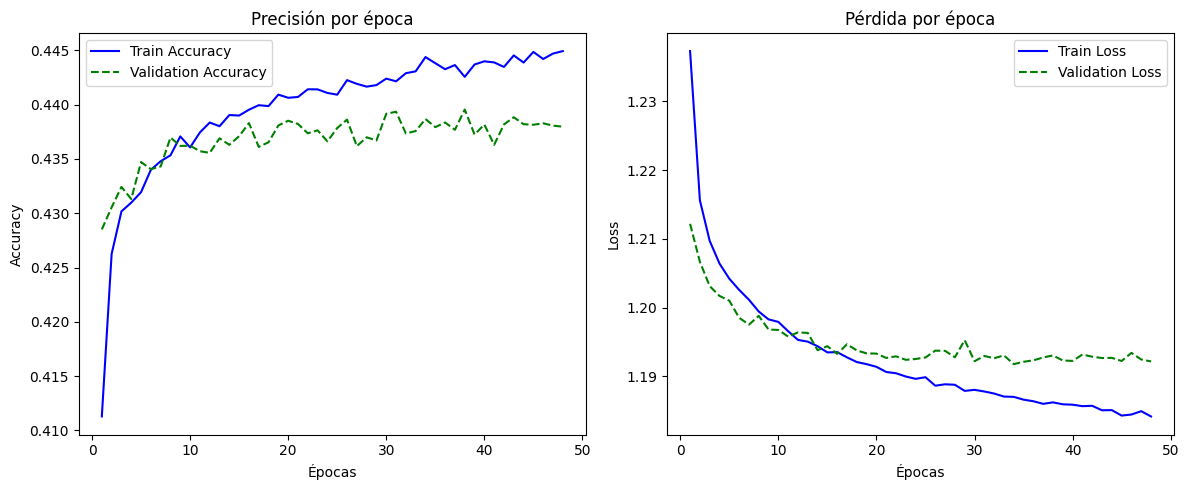

In [ ]:
plot_training_history(history)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict({'dense_input': Xts, 'program_input': Xts_int })
print(classification_report(yts.values.argmax(axis=1), y_pred.argmax(axis=1)))

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.56      0.51     51902
           1       0.34      0.28      0.31     51790
           2       0.33      0.27      0.30     51263
           3       0.56      0.65      0.60     52795

    accuracy                           0.44    207750
   macro avg       0.42      0.44      0.43    207750
weighted avg       0.42      0.44      0.43    207750



#####Usando Keras Tuner

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def build_model(hp):

    input_dense = tf.keras.Input(shape=(Xtr.shape[1],), name="dense_input")
    input_program = tf.keras.Input(shape=(1,), name="program_input")

    # Embedding layer
    embedding = tf.keras.layers.Embedding(input_dim=949, output_dim=10)(input_program)
    embedding_flat = tf.keras.layers.Flatten()(embedding)

    concat = tf.keras.layers.Concatenate()([input_dense, embedding_flat])
    # 2 or 3 layers
    n_layers = hp.Int("num_layers", 2, 3)

    if n_layers == 2:
      # layer 1
      units = hp.Int(f"units_{0}", min_value=152, max_value=280, step=32)
      activation = hp.Choice(f"activation_{0}", values=["relu", "tanh", "gelu"])
      x = tf.keras.layers.Dense(units, activation=activation)(concat)
      x = tf.keras.layers.Dropout(hp.Float(f"dropout_{0}", 0.1, 0.25, step=0.05))(x)
      # layer 2
      units = hp.Int(f"units_{1}", min_value=42, max_value=138, step=32)
      activation = hp.Choice(f"activation_{1}", values=["relu", "tanh", "gelu"])
      x = tf.keras.layers.Dense(units, activation=activation)(x)
      x = tf.keras.layers.Dropout(hp.Float(f"dropout_{1}", 0.1, 0.25, step=0.05))(x)

    elif n_layers == 3:
      # layer 1
      units = hp.Int(f"units_{0}", min_value=180, max_value=308, step=32)
      activation = hp.Choice(f"activation_{0}", values=["relu", "tanh", "gelu"])
      x = tf.keras.layers.Dense(units, activation=activation)(concat)
      x = tf.keras.layers.Dropout(hp.Float(f"dropout_{0}", 0.20, 0.30, step=0.05))(x)
      # layer 2
      units = hp.Int(f"units_{1}", min_value=96, max_value=224, step=32)
      activation = hp.Choice(f"activation_{1}", values=["relu", "tanh", "gelu"])
      x = tf.keras.layers.Dense(units, activation=activation)(concat)
      x = tf.keras.layers.Dropout(hp.Float(f"dropout_{1}", 0.20, 0.30, step=0.05))(x)
      # layer 3
      units = hp.Int(f"units_{2}", min_value=42, max_value=138, step=32)
      activation = hp.Choice(f"activation_{2}", values=["relu", "tanh", "gelu"])
      x = tf.keras.layers.Dense(units, activation=activation)(x)
      x = tf.keras.layers.Dropout(hp.Float(f"dropout_{2}", 0.15, 0.25, step=0.05))(x)

    # Output
    output = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_dense, input_program], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="kerastuner_dir",
    project_name="accuracy_tuning3"
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
tuner.search({'dense_input': Xtr, 'program_input': Xtr_int}, ytr, epochs=50, validation_split=0.2, batch_size=512,
             verbose=1, callbacks=[early_stop])

Trial 10 Complete [00h 07m 34s]
val_accuracy: 0.4416916072368622

Best val_accuracy So Far: 0.4416916072368622
Total elapsed time: 00h 59m 41s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")


Mejores hiperparámetros:
num_layers: 2
units_0: 152
activation_0: gelu
dropout_0: 0.2
units_1: 138
activation_1: gelu
dropout_1: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_pred = best_model.predict({'dense_input': Xts, 'program_input': Xts_int })
print(classification_report(yts.values.argmax(axis=1), y_pred.argmax(axis=1)))

6493/6493 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
              precision    recall  f1-score   support

           0       0.47      0.57      0.51     51902
           1       0.34      0.23      0.27     51790
           2       0.33      0.33      0.33     51263
           3       0.57      0.64      0.60     52795

    accuracy                           0.44    207750
   macro avg       0.43      0.44      0.43    207750
weighted avg       0.43      0.44      0.43    207750



Tomaremos entonces este modelo base con embedding inicial y dos capas densas como el modelo inicial para posterior predicción y optimización final. De acuerdo a los resultados el modelo optimo es aquel que usa

1. Capa de embedding sobre el labeling aplicado a la columna de programa académico
2. Dos capas densas con 152 y 138 neuronas respectivamente y activaciones gelu
3. Capas de Dropout intermedias de 0.20
4. Capa de salida usual con activación softmax y 4 neuronas de salida

Función de perdida puede ser utilizada el CategoricalCrossentropy original o focalizada